# Machine learning for Credit Card Transactions

In [18]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

default_edge_color = 'gray'
default_node_color = '#407cc9'
enhanced_node_color = '#f5b042'
enhanced_edge_color = '#cc2f04'

## Load Dataset and build graph

In [19]:
import pandas as pd
# df = pd.read_csv("/Users/claudiostamile/Downloads/fraudTrain.csv")
df = pd.read_csv("../data/fraudTrain.csv")
df = df[df["is_fraud"]==0].sample(frac=0.20, random_state=42).append(df[df["is_fraud"] == 1])
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
811778,811778,2019-12-07 10:55:06,676173792455,"fraud_Zieme, Bode and Dooley",gas_transport,86.19,Brittany,Cox,F,07177 William Dale Apt. 547,...,34.0287,-118.4924,92043,"Civil engineer, contracting",1961-04-25,f32d1f4b2a918f4c2f6acdc83033ee35,1354877706,33.287851,-118.740970,0
1101718,1101718,2020-04-03 13:10:06,30518206766474,fraud_Lind-Buckridge,entertainment,85.81,Tamara,Martinez,F,471 Marquez Prairie Suite 680,...,36.7154,-89.6287,1019,Aeronautical engineer,1979-01-26,f5dad8e2d7c39d81502d846a20286659,1364994606,36.539950,-89.857416,0
800013,800013,2019-12-04 07:07:04,4658490815480264,fraud_Hackett-Lueilwitz,grocery_pos,99.30,Tara,Richards,F,4879 Cristina Station,...,39.9636,-79.7853,184,Systems developer,1945-11-04,1d023bc78ab93ab65a35bbb53bcc67bd,1354604824,39.582872,-78.838550,0
398945,398945,2019-06-30 18:43:08,4716561796955522,fraud_Lynch-Wisozk,home,42.09,Lauren,Anderson,F,11014 Chad Lake Apt. 573,...,48.2777,-112.8456,743,Water engineer,1972-05-04,dbf6c06d3277438afdf7af883fb4285f,1341081788,48.310513,-112.837535,0
207455,207455,2019-04-15 19:57:49,3528407217576457,fraud_Fisher-Schowalter,shopping_net,4.24,Patricia,Leach,F,71309 Martinez Stravenue,...,36.4715,-82.4834,87124,Warden/ranger,1987-02-14,88814660aba0101b174e1e8137f4a7af,1334519869,37.329094,-82.070746,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295399,1295399,2020-06-21 01:00:08,3524574586339330,fraud_Kassulke PLC,shopping_net,977.01,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,...,27.6330,-80.4031,105638,"Librarian, public",1986-05-07,a83b093f0c1d9068fa0089f7c722615f,1371776408,26.888686,-80.834389,1
1295491,1295491,2020-06-21 01:53:35,3524574586339330,fraud_Schumm PLC,shopping_net,1210.91,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,...,27.6330,-80.4031,105638,"Librarian, public",1986-05-07,f75b35bed13b9e692f170dba45a15b21,1371779615,28.216707,-79.855648,1
1295532,1295532,2020-06-21 02:16:56,4005676619255478,"fraud_Tillman, Dickinson and Labadie",gas_transport,10.24,William,Perry,M,458 Phillips Island Apt. 768,...,30.4590,-90.9027,71335,Herbalist,1994-05-31,a0ba2472cd3fc9731f2a18d3f308f5c3,1371781016,29.700456,-91.361632,1
1295666,1295666,2020-06-21 03:26:20,3560725013359375,fraud_Corwin-Collins,gas_transport,21.69,Brooke,Smith,F,63542 Luna Brook Apt. 012,...,31.8599,-102.7413,23,Cytogeneticist,1969-09-15,daa281350b1e16093c7b4bf97bf4d6ed,1371785180,32.675272,-103.484949,1


In [3]:
df["is_fraud"].value_counts()

0    257834
1      7506
Name: is_fraud, dtype: int64

In [4]:
def build_graph_bipartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
    df["from"] = df["cc_num"].apply(lambda x: mapping[x])
    df["to"] = df["merchant"].apply(lambda x: mapping[x])
    df = df[['from', 'to', "amt", "is_fraud"]].groupby(['from', 'to']).agg({"is_fraud": "sum", "amt": "sum"}).reset_index()
    df["is_fraud"] = df["is_fraud"].apply(lambda x: 1 if x>0 else 0)
    
    G = nx.from_edgelist(df[["from", "to"]].values, create_using=graph_type)
    
    nx.set_node_attributes(G,{x:1 for x in df["from"].unique()}, "bipartite")
    nx.set_node_attributes(G,{x:2 for x in df["to"].unique()}, "bipartite")
    
    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["is_fraud"] for idx, x in df[["from","to","is_fraud"]].iterrows()}, 
                       "label")

    nx.set_edge_attributes(G, 
                       {(int(x["from"]), int(x["to"])):x["amt"] for idx, x in df[["from","to","amt"]].iterrows()}, 
                       "weight")
    return G

In [5]:
def build_graph_tripartite(df_input, graph_type=nx.Graph()):
    df = df_input.copy()
    mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist() + 
                                                        df["cc_num"].values.tolist() + 
                                                        df["merchant"].values.tolist()))}
    df["in_node"] = df["cc_num"].apply(lambda x: mapping[x])
    df["out_node"] = df["merchant"].apply(lambda x: mapping[x])

    G = nx.from_edgelist([(x["in_node"], mapping[idx]) for idx, x in df.iterrows()] +
                         [(x["out_node"], mapping[idx]) for idx, x in df.iterrows()], 
                         create_using=graph_type)

    nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()}, "bipartite")
    nx.set_node_attributes(G,{mapping[idx]:3 for idx, x in df.iterrows()}, "bipartite")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["is_fraud"] for idx, x in df.iterrows()}, "label")

    nx.set_edge_attributes(G,{(x["in_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    nx.set_edge_attributes(G,{(x["out_node"], mapping[idx]):x["amt"] for idx, x in df.iterrows()}, "weight")
    return G

In [6]:
G = build_graph_bipartite(df, nx.Graph())

In [7]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G)

True

/home/studio-lab-user/.conda/envs/my37g/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


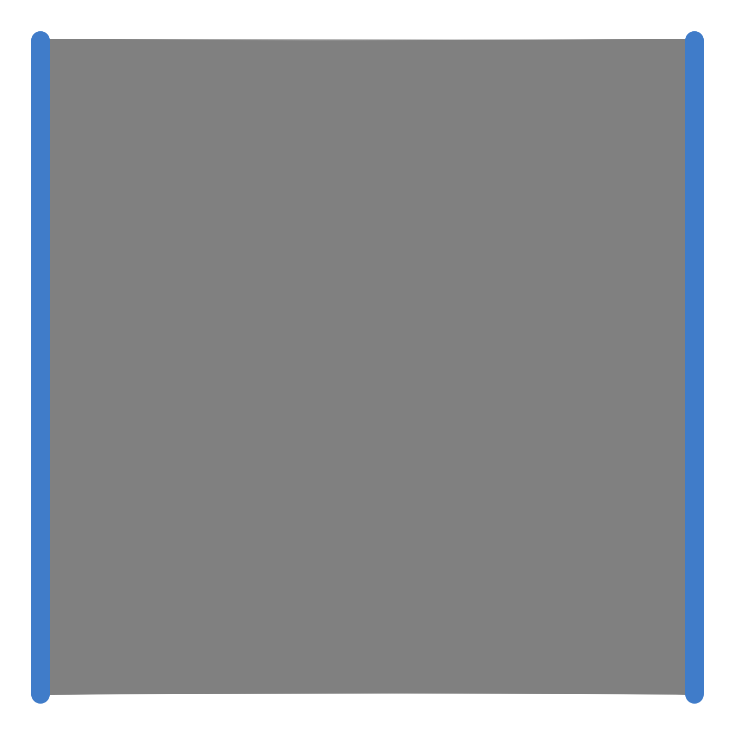

In [8]:
plt.figure(figsize=(10,10))
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
nx.draw(G, pos=pos, with_labels=False, node_color=default_node_color, edge_color=default_edge_color)
plt.show()

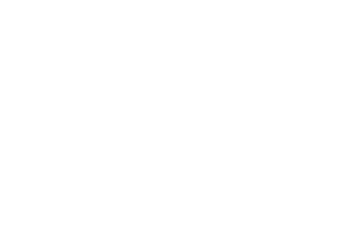

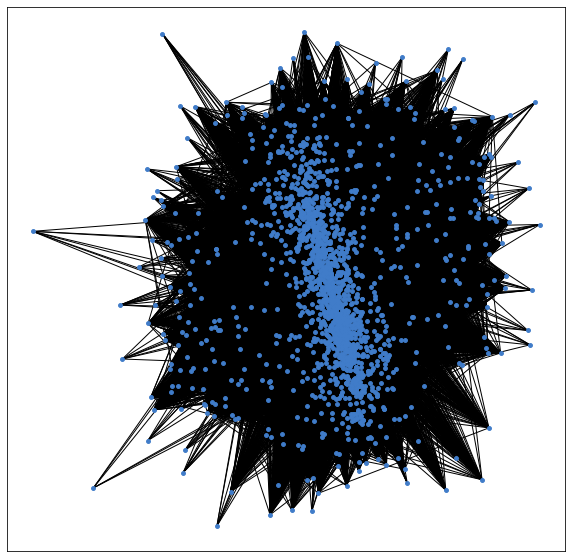

In [10]:
plt.axis("off")
plt.figure(figsize=(10,10))

spring_pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=spring_pos, node_color=default_node_color, 
                 edges_color=default_edge_color, with_labels=False, node_size=15)

## Network Analysis

In [ ]:
print(nx.info(G))

In [ ]:
plt.figure(figsize=(10,10))
degrees = pd.Series({k: v for k, v in nx.degree(G)})
degrees.plot.hist()
plt.yscale("log")

In [ ]:
allEdgesWeights = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True)})
np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9,1.0])

In [ ]:
quant_dist = np.quantile(allEdgesWeights.values,[0.10,0.50,0.70,0.9])
quant_dist

In [ ]:
allEdgesWeightsFiltered = pd.Series({(d[0], d[1]): d[2]["weight"] for d in G.edges(data=True) 
                                     if d[2]["weight"] < quant_dist[-1]})

In [ ]:
plt.figure(figsize=(10,10))
allEdgesWeightsFiltered.plot.hist(bins=40)
plt.yscale("log")

In [ ]:
plt.figure(figsize=(10,10))
bC = nx.betweenness_centrality(G)
bc_distr = pd.Series(bC)
bc_distr.plot.hist()
plt.yscale("log")

In [ ]:
np.mean(list(bC.values()))

In [ ]:
# degree centrality
plt.figure(figsize=(10,10))
deg_C = nx.degree_centrality(G)
degc_distr = pd.Series(deg_C)
degc_distr.plot.hist()

In [ ]:
# closeness centrality
plt.figure(figsize=(10,10))
clos_C = nx.closeness_centrality(G)
closc_distr = pd.Series(clos_C)
closc_distr.plot.hist()

In [ ]:
np.mean(list(clos_C.values()))

In [ ]:
# assortativity
nx.degree_pearson_correlation_coefficient(G)

### Community Detection

In [ ]:
import community

parts = community.best_partition(G, random_state=42, weight='weight')

In [ ]:
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

In [ ]:
graphs = []
d = {}
for x in communities.unique():
    tmp = nx.subgraph(G, communities[communities==x].index)
    fraud_edges = sum(nx.get_edge_attributes(tmp, "label").values())
    ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges())*100
    d[x] = ratio
    graphs += [tmp]

pd.Series(d).sort_values(ascending=False)

In [ ]:
gId = 10
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x == 1 else "g" for x in nx.get_edge_attributes(graphs[gId], 'label').values()]
nx.draw_networkx(graphs[gId], pos=spring_pos, node_color=default_node_color, 
                 edge_color=edge_colors, with_labels=False, node_size=15)

## Supervised Learning

In [11]:
from sklearn.utils import resample

df_majority = df[df.is_fraud==0]
df_minority = df[df.is_fraud==1]

df_maj_dowsampled = resample(df_majority,
                             n_samples=len(df_minority),
                             random_state=42)

df_downsampled = pd.concat([df_minority, df_maj_dowsampled])

print(df_downsampled.is_fraud.value_counts())
G_down = build_graph_bipartite(df_downsampled)

1    7506
0    7506
Name: is_fraud, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split


train_edges, test_edges, train_labels, test_labels = train_test_split(list(range(len(G_down.edges))), 
                                                                      list(nx.get_edge_attributes(G_down, "label").values()), 
                                                                      test_size=0.20, 
                                                                      random_state=42)

In [13]:
edgs = list(G_down.edges)
train_graph = G_down.edge_subgraph([edgs[x] for x in train_edges]).copy()
train_graph.add_nodes_from(list(set(G_down.nodes) - set(train_graph.nodes)))

In [14]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder

node2vec_train = Node2Vec(train_graph, weight_key='weight')
model_train = node2vec_train.fit(window=10)


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:48<00:00,  4.88s/it]


In [15]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
for cl in classes:
    embeddings_train = cl(keyed_vectors=model_train.wv) 

    train_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in train_edges]
    test_embeddings = [embeddings_train[str(edgs[x][0]), str(edgs[x][1])] for x in test_edges]
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
    rf.fit(train_embeddings, train_labels); 

    y_pred = rf.predict(test_embeddings)
    print(cl)
    print('Precision:', metrics.precision_score(test_labels, y_pred)) 
    print('Recall:', metrics.recall_score(test_labels, y_pred)) 
    print('F1-Score:', metrics.f1_score(test_labels, y_pred)) 

<class 'node2vec.edges.HadamardEmbedder'>
Precision: 0.7652859960552268
Recall: 0.5197588747488279
F1-Score: 0.6190666134822497
<class 'node2vec.edges.AverageEmbedder'>
Precision: 0.7341211225997046
Recall: 0.6657736101808439
F1-Score: 0.698278890059712
<class 'node2vec.edges.WeightedL1Embedder'>
Precision: 0.6166259168704157
Recall: 0.8446081714668453
F1-Score: 0.712832108535896
<class 'node2vec.edges.WeightedL2Embedder'>
Precision: 0.618208516886931
Recall: 0.8459477561955794
F1-Score: 0.7143665158371042


## Unupervised Learning

In [16]:
nod2vec_unsup = Node2Vec(G_down, weight_key='weight')
unsup_vals = nod2vec_unsup.fit(window=10)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


In [17]:
from sklearn.cluster import KMeans

classes = [HadamardEmbedder, AverageEmbedder, WeightedL1Embedder, WeightedL2Embedder]
true_labels = [x for x in nx.get_edge_attributes(G_down, "label").values()]

for cl in classes:
    embedding_edge = cl(keyed_vectors=unsup_vals.wv) 

    embedding = [embedding_edge[str(x[0]), str(x[1])] for x in G_down.edges()]
    kmeans = KMeans(2, random_state=42).fit(embedding)
    
    
    nmi = metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_)
    ho = metrics.homogeneity_score(true_labels, kmeans.labels_)
    co = metrics.completeness_score(true_labels, kmeans.labels_)
    vmeasure = metrics.v_measure_score(true_labels, kmeans.labels_)
    
    print(cl)
    print('NMI:', nmi)
    print('Homogeneity:', ho)
    print('Completeness:', co)
    print('V-Measure:', vmeasure)

<class 'node2vec.edges.HadamardEmbedder'>
NMI: 0.3434761733070354
Homogeneity: 0.33186917904313046
Completeness: 0.3559965316541601
V-Measure: 0.34350971378557277
<class 'node2vec.edges.AverageEmbedder'>
NMI: 0.07509163068752496
Homogeneity: 0.07434583487085315
Completeness: 0.0759467520741665
V-Measure: 0.07513776698446421
<class 'node2vec.edges.WeightedL1Embedder'>
NMI: 0.06292837593355008
Homogeneity: 0.06297662275863868
Completeness: 0.0629726266511482
V-Measure: 0.06297462464149936
<class 'node2vec.edges.WeightedL2Embedder'>
NMI: 0.05118782384823713
Homogeneity: 0.05066598619086717
Completeness: 0.05181730760841758
V-Measure: 0.0512351797918955
